In [60]:
#Import delle librerie
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform, randint # Fondamentale per le distribuzioni
from sklearn.model_selection import RandomizedSearchCV

In [61]:
# si importa il dataset ionosphere da openml
ionosphere = sk.datasets.fetch_openml(name = "ionosphere")

# si crea il dataframe
df_ionosphere = pd.DataFrame(data = ionosphere.data, columns = ionosphere.feature_names)

# si aggiunge la colonna delle etichette di classe
class_labels = pd.Series(ionosphere.target, name = "class")

# si concatena la colonna delle etichette al dataframe
df_ionosphere = pd.concat([df_ionosphere, class_labels], axis = 1)

# si visualizzano le prime righe del dataframe
df_ionosphere.head()

,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,...,a26,a27,a28,a29,a30,a31,a32,a33,a34,class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


### Descrizione delle feature

In [62]:
print(ionosphere.DESCR)

**Author**: Space Physics Group, Applied Physics Laboratory, Johns Hopkins University. Donated by Vince Sigillito.  
**Source**: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/ionosphere)  
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html) 

**Johns Hopkins University Ionosphere database**  
This radar data was collected by a system in Goose Bay, Labrador.  This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts.  See the paper for more details.  

### Attribute information
Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number.  There were 17 pulse numbers for the Goose Bay system.  Instances in this database are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

The targets were free 

# INIZIO ANALISI DEL DATASET
#### Cosa rappresentano queste feature?

Questi dati radar sono stati presi da un sistema di 16 antenne ad alta frequenza situato a Labrador, Goose Bay.
Lo scopo di questo sistema è studiare la fisica della ionosfera. La ionosfera è uno strato dell'atomosfera terrestre situata tra i 50 e i 700 km di altitudine. Nella ionosfera i raggi X ad alta energia e gli UV collidono con le molecole di gas ionizzandole. Questo processo consiste nello staccare un elettrone o più dalla molecola di gas, creando una coppia elettrone/ione positivo. Questa parte dell'atomosfera ha una grande quantità di elettroni liberi (non legati a nessuna molecola).

Lo scopo di queste 16 antenne è sparare impulsi radio verso la ionosfera e "ascoltare" gli echi che tornano indietro. Questi echi sono riflessi dai "bersagli", che in questo caso sono gli elettroni liberi presenti nella ionosfera.

Il segnale ricevuto dall'antenna (eco degli elettroni liberi) è una funzione complessa, contiene una parte immaginaria e una reale.

Per analizzare il segnale, il sistema non usa i dati grezzi ma calcola la funzione di autocorrelazione. Questa funzione, in pratica, misura quanto il segnale è simile a sé stesso in diversi momenti. Il numero di momenti successivi per cui viene calcolata questa funzione è 17.

Il segnale è complesso, quindi per ogni momento successivo in cui si calcola la ACF si ha una parte reale e una immaginaria. Quindi, i momenti successivi sono 17, allora il numero di risultati sarà 34 (numero delle feature).
Quindi le feature di questo dataset sono le parti reali e immaginarie della funzione di autocorrelazione calcolata in 17 momenti successivi rispetto al primo.

Il sistema radar genera 25 di queste 17 coppie di numeri ogni 5 secondi per tutto un anno (molti). Quindi, ci sono molti segnali che possono essere brutti o buoni.

I valori delle feature sono già normalizzati nell'intervallo [-1, +1].

I risultati buoni indicano la presenza di una struttura nella ionosfera. I risultati brutti possono essere causati da diversi fattori: il segnale non rimbalza da nessuna parte quindi va fuori dalla ionosfera (nessuna struttura), il segnale rimbalza in troppe strutture e quindi si cancella/attenua troppo, assorbimento degli impulsi radar oppure da interferenza con altri trasmettitori. Quindi i segnali brutti sono più variegati rispetto a quelli buoni.


Cosa vogliono dire i valori [-1, 1]?

Se il valore è uguale a 1 allora si ha perfetta correlazione tra il segnale all'inizio e quello all'istante k successivo (sono identici).
Se il valore è uguale a 0 allora non si ha correlazione tra i due segnali (sono completamente diversi, scorrelati, statisticamente indipendenti)
Se il valore è uguale a -1 allora si ha perfetta anticorrelazione, ovvero il segnale è specchiato perfettamente.

I segnale buoni (presenza di struttura) hanno dei valori di ACF che non cambiano troppo velocemente durante quei 17 momenti successivi. I segnali cattivi hanno valori di ACF super casuali (oscillano intorno allo zero praticamente).

### Si mostrano dei grafici delle ACF

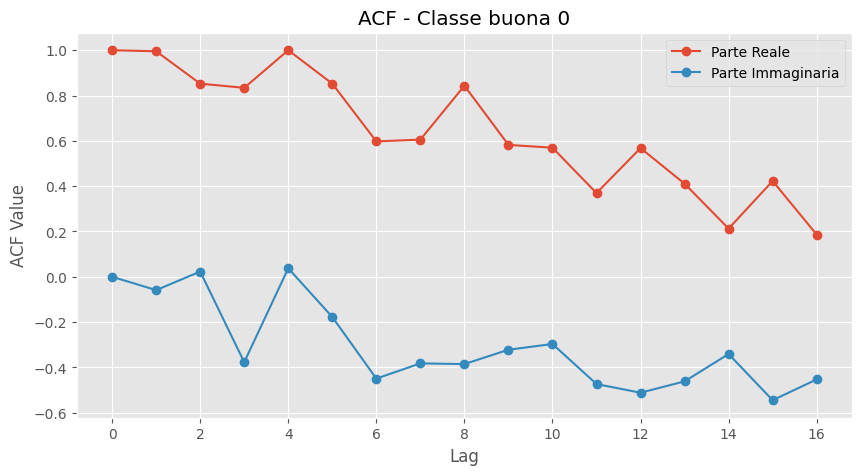

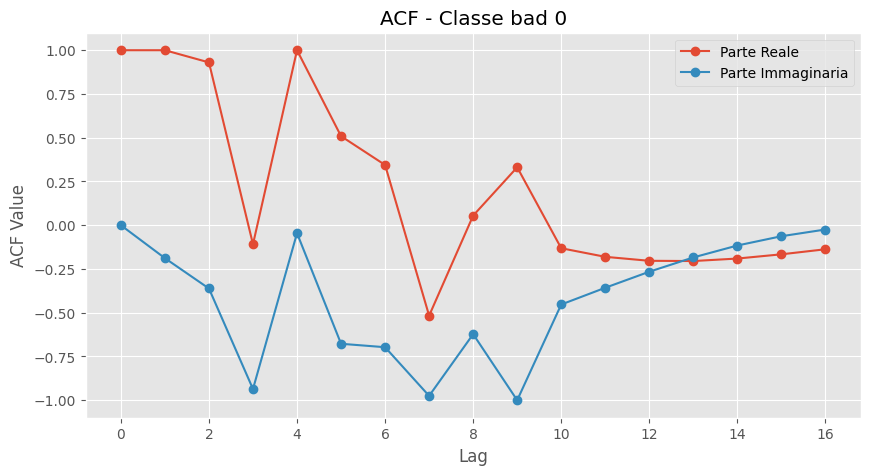

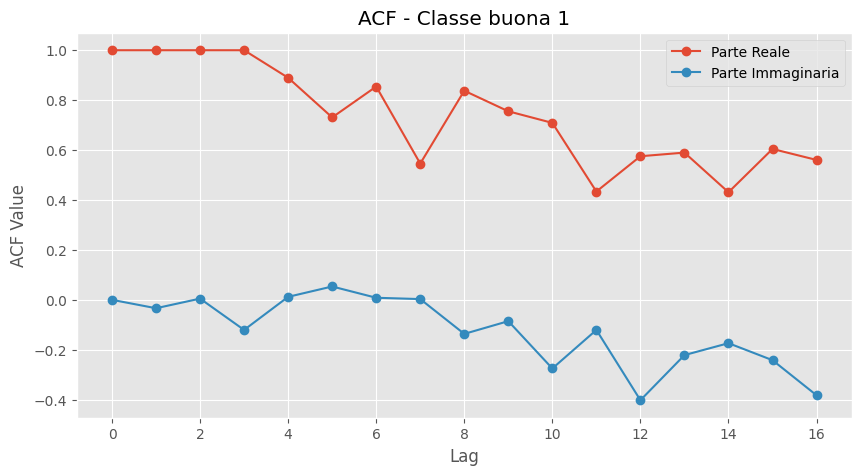

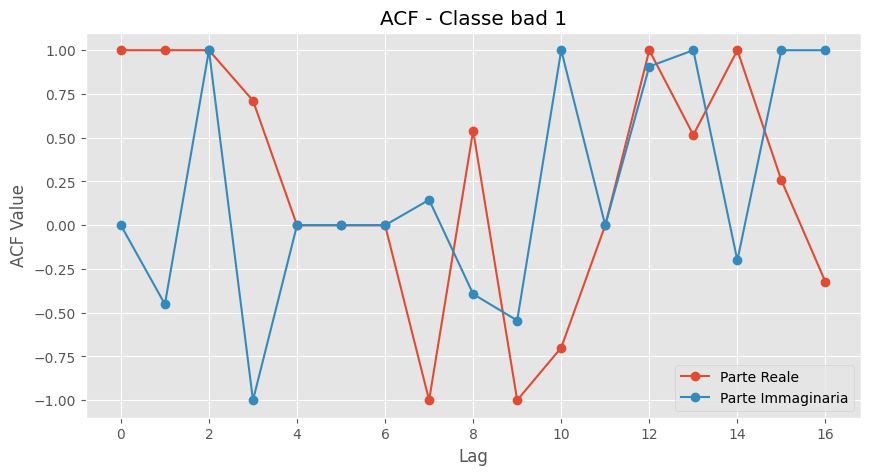

In [63]:
# estraggo le prime due righe di ciascuna classe
righe_good = df_ionosphere[df_ionosphere['class'] == 'g'].head(2).values
righe_bad = df_ionosphere[df_ionosphere['class'] == 'b'].head(2).values

# estraggo i primi 34 valori di ciascuna riga, eliminando l'etichetta di classe
riga_good_0 = righe_good[0][0:34]
riga_bad_0 = righe_bad[0][0:34]
riga_good_1 = righe_good[1][0:34]
riga_bad_1 = righe_bad[1][0:34]

# separo le feature che rappresenta la parte immaginaria e reale della acf
riga_good_0_reale = riga_good_0[0::2]
riga_good_0_immaginario = riga_good_0[1::2]
riga_bad_0_reale = riga_bad_0[0::2]
riga_bad_0_immaginario = riga_bad_0[1::2]

riga_good_1_reale = riga_good_1[0::2]
riga_good_1_immaginario = riga_good_1[1::2]
riga_bad_1_reale = riga_bad_1[0::2]
riga_bad_1_immaginario = riga_bad_1[1::2]


# grafico acf 0 good
plt.figure(figsize=(10, 5))
plt.plot(riga_good_0_reale, label='Parte Reale', marker='o')
plt.plot(riga_good_0_immaginario, label='Parte Immaginaria', marker='o')
plt.title('ACF - Classe buona 0')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.legend()

# grafico acf 0 bad
plt.figure(figsize=(10, 5))
plt.plot(riga_bad_0_reale, label='Parte Reale', marker='o')
plt.plot(riga_bad_0_immaginario, label='Parte Immaginaria', marker='o')
plt.title('ACF - Classe bad 0')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.legend()

# grafico acf 1 good
plt.figure(figsize=(10, 5))
plt.plot(riga_good_1_reale, label='Parte Reale', marker='o')
plt.plot(riga_good_1_immaginario, label='Parte Immaginaria', marker='o')
plt.title('ACF - Classe buona 1')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.legend()

# grafico acf 1 bad
plt.figure(figsize=(10, 5))
plt.plot(riga_bad_1_reale, label='Parte Reale', marker='o')
plt.plot(riga_bad_1_immaginario, label='Parte Immaginaria', marker='o')
plt.title('ACF - Classe bad 1')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.legend()
plt.show()

Grafico torta per vedere se è sbilanciato
Grafico coordinate parallele prima della scalatura e dopo. Nel mio caso non c'è bisogno perchè sono già tutte scalate a [-1,1]

### Grafico a torta per capire come sono distribuite le classi

Text(0.5, 1.0, 'Distribuzione delle classi nel dataset Ionosphere')

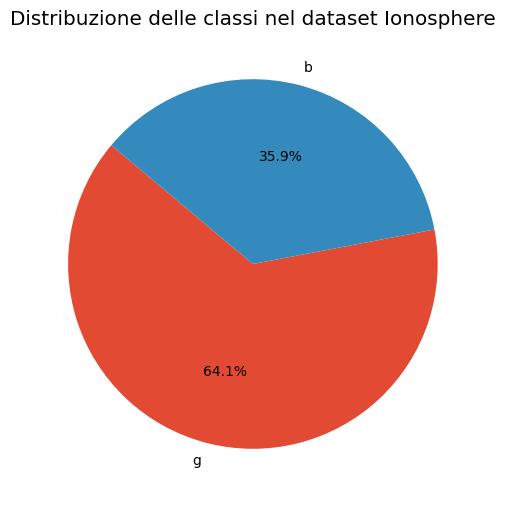

In [64]:
#### Grafico a torta per capire come sono distribuite le classi
class_counts = df_ionosphere['class'].value_counts()
labels = class_counts.index
sizes = class_counts.values
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribuzione delle classi nel dataset Ionosphere') 

# Distribuzione delle feature differenziate per classi

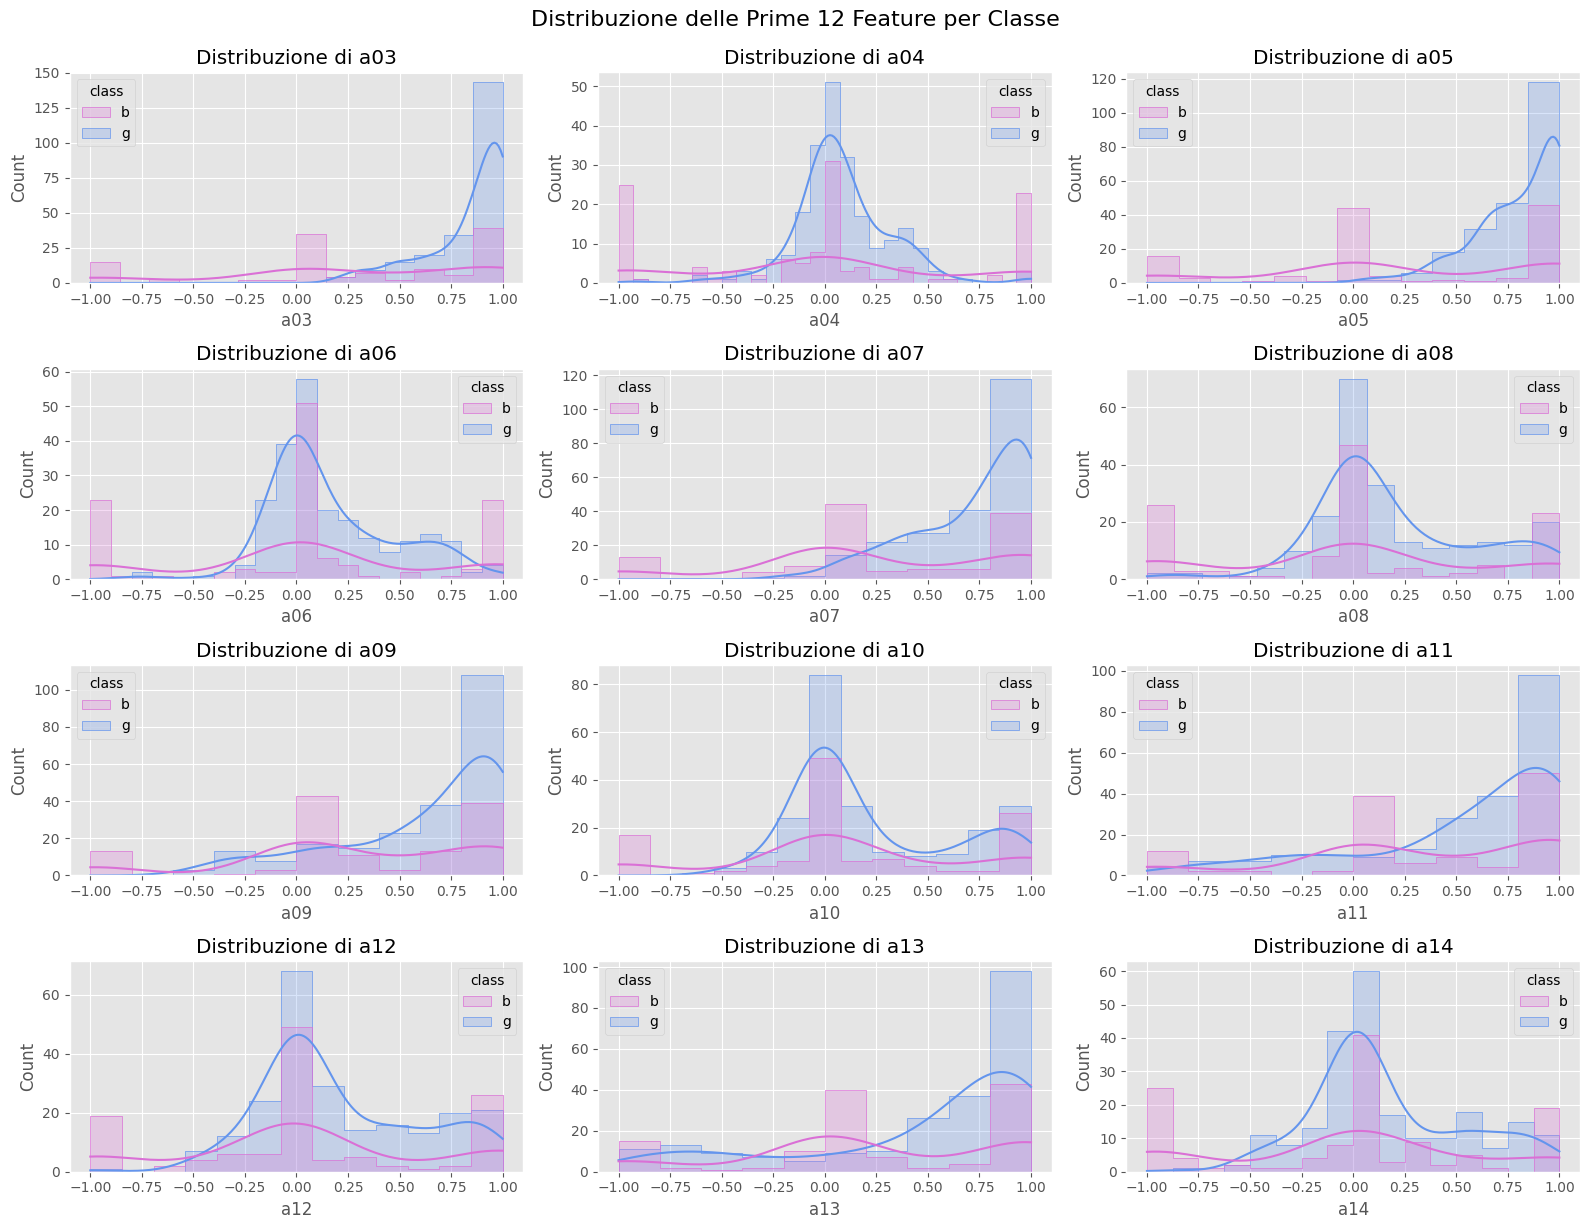

In [65]:
# Prime 12 feature
class_map = {'g': 'Good signal', 'b': 'Bad signal'}
color_map_dict = {'g': 'cornflowerblue', 'b': 'orchid'}
feature_column_names = ionosphere.feature_names

features_to_plot = feature_column_names[2:14]

# Costruisci la palette 
palette = {label: color for label, color in color_map_dict.items()}

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.histplot(
        df_ionosphere,
        x=feature,
        hue='class',
        kde=True,
        palette=palette,
        element='step'
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Prime 12 Feature per Classe', y=1.02, fontsize=16)
plt.show()

Da queste distribuzioni si può notare che i dati "bad" mantengono la media vicino allo zero, perchè questi segnali non rappresentano nessuna struttura della ionosfera e quindi non sono periodici ma casuali e quindi la loro media deve essere zero.
Mentre per i dati "good" si può notare che per feature pari la media è vicino allo zero mentre per quelle dispari la media è lontano dallo zero e verso 1. Perchè in questo caso viene rilevata una struttura nella ionosfera ed è un segnale periodico.

### Matrice di correlazione tra le feature

Text(0.5, 1.0, "Matrice di Correlazione delle Feature dell'Ionosphere Dataset")

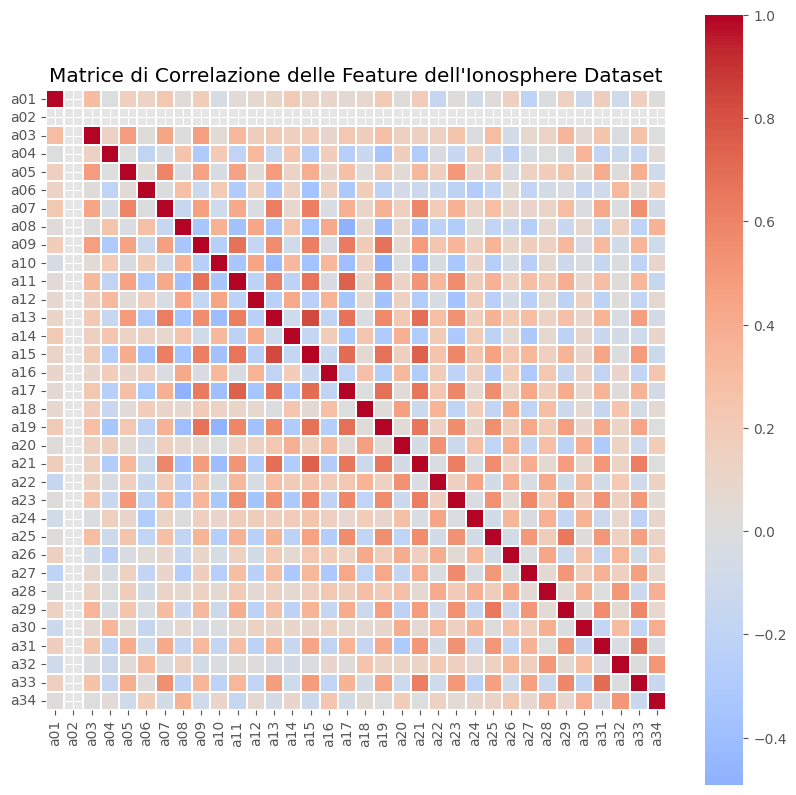

In [66]:
# Matrice di correlazione
plt.figure(figsize=(10, 10))
correlation_matrix = df_ionosphere.iloc[:, :-1].corr(method='pearson')  # Escludi la colonna delle etichette di classe
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, center=0, linewidths=0.3)
plt.title('Matrice di Correlazione delle Feature dell\'Ionosphere Dataset')

Lo stesso si nota qui. Questa matrice di correlazione calcolata con il metodo pearson (controllo se sono lineari) mostra linearità a tratti (motivo a scacchiera). Questo è compatibile con la periodicità dei segnali "good".

### Box plot delle feature

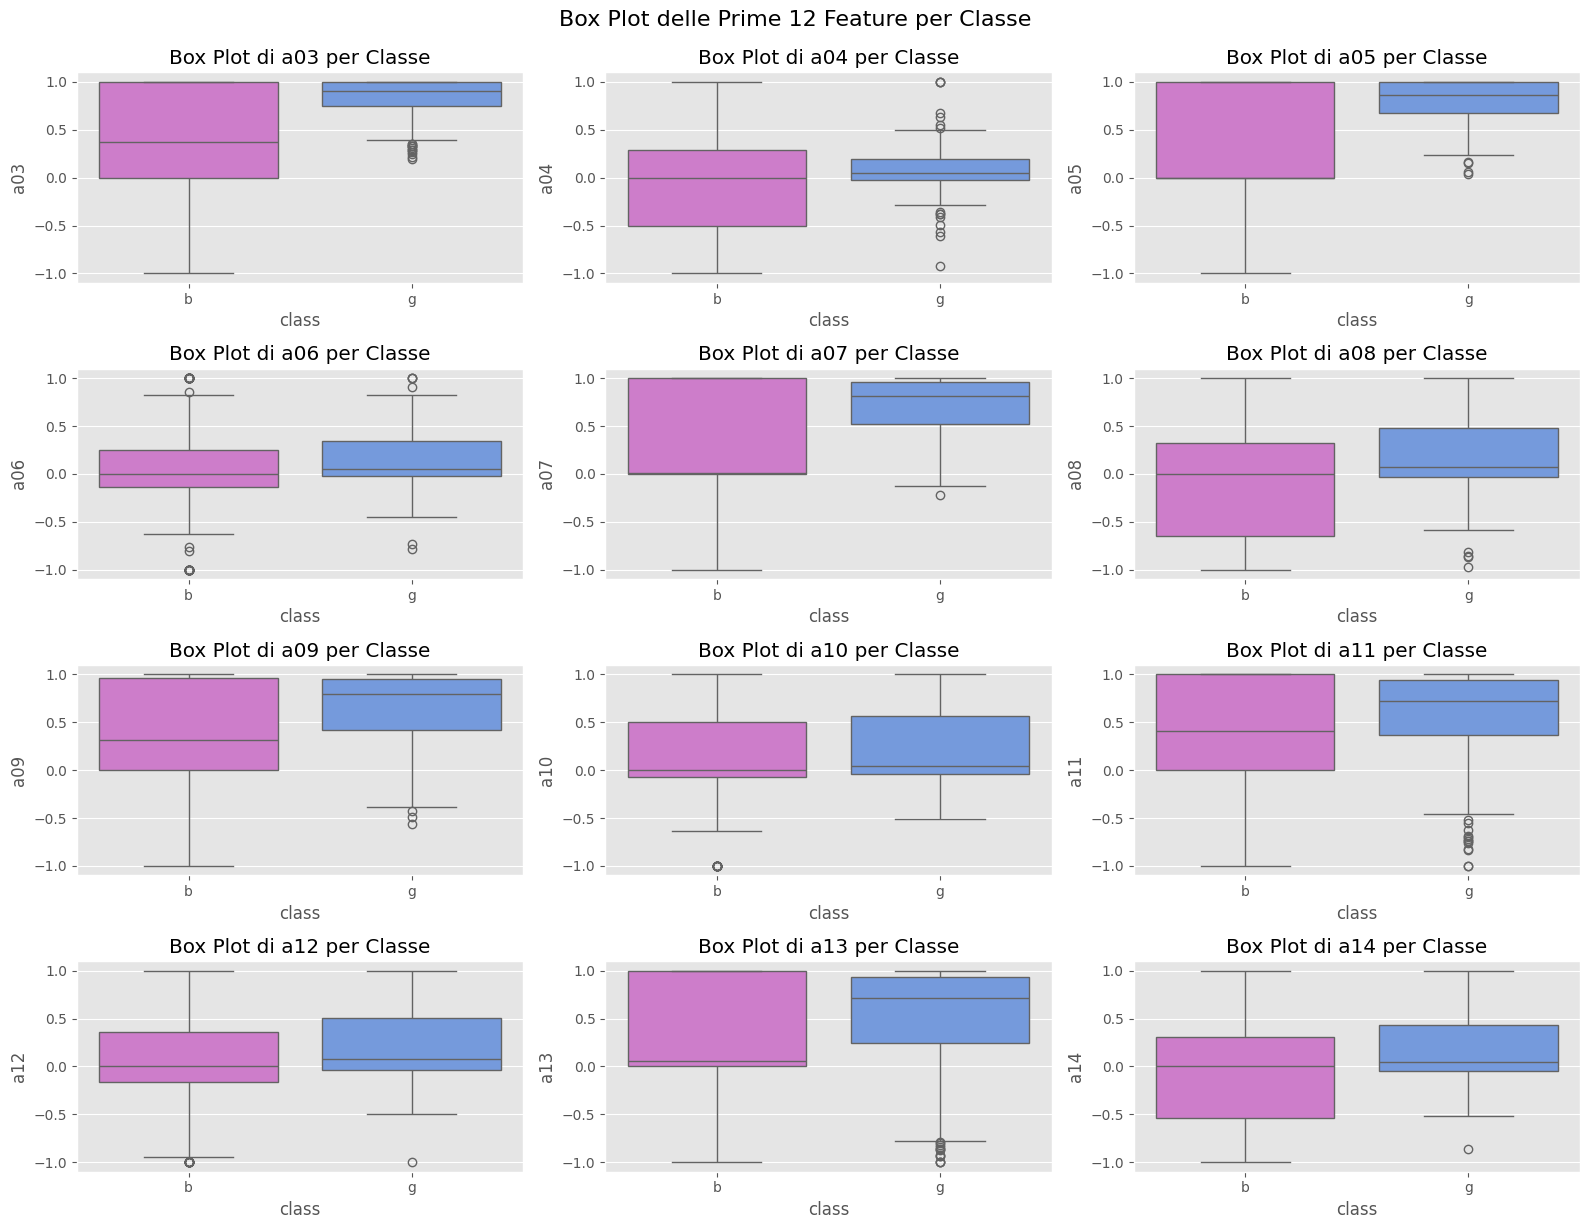

In [67]:
# Box plot delle feature
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(
        data=df_ionosphere,
        x='class',
        y=feature,
        palette=palette,
        hue='class'
    )
    plt.title(f'Box Plot di {feature} per Classe')
plt.tight_layout()
plt.suptitle('Box Plot delle Prime 12 Feature per Classe', y=1.02, fontsize=16)
plt.show()

Lo stesso della descrizione sotto il plot delle distribuzioni.

### Parallel coordinates plot

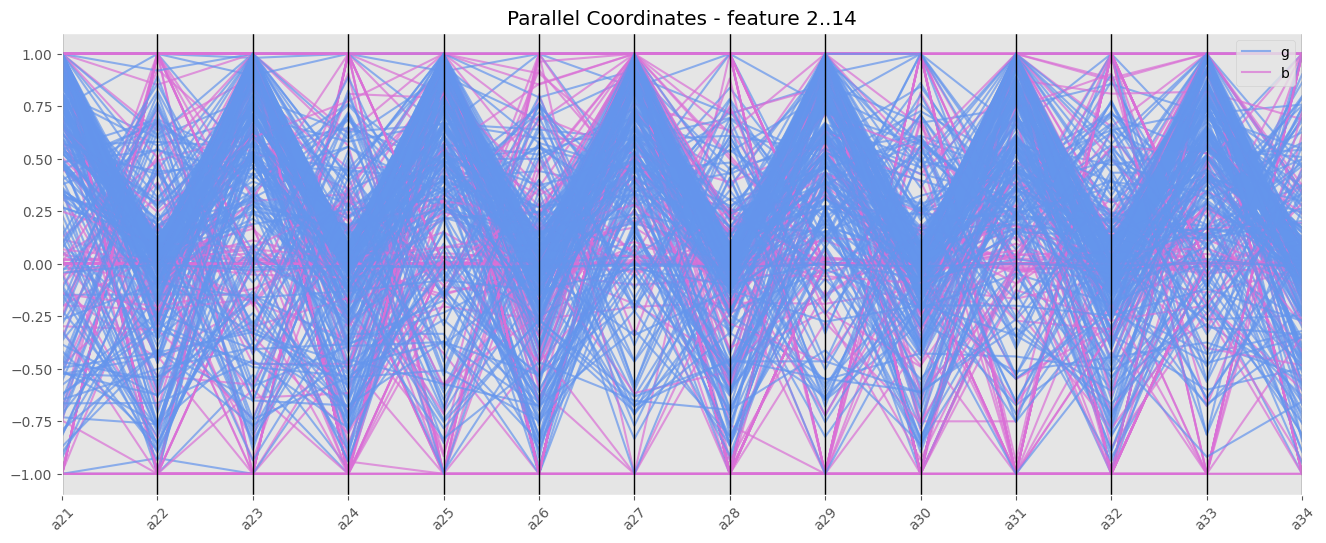

In [68]:
# Coordinate parallele solo dalle feature
feature_column_names = ionosphere.feature_names

features_to_plot = feature_column_names[20:34]
cols = features_to_plot
plt.figure(figsize=(16, 6))
colors = [palette[label] for label in labels]  # palette e labels esistenti
parallel_coordinates(df_ionosphere[cols + ['class']], 'class', color=colors, alpha=0.7)
plt.title('Parallel Coordinates - feature 2..14')
plt.xticks(rotation=45)
plt.show()

Si nota che andando avanti con le feature i dati diventano più rumorosi. Questo è ragionevole perchè il segnale buono non è periodico per sempre ma piano piano si attenua. Però si nota che alcuni segnali buoni formano una banda blu. Questi segnali sono quelli migliori (credo) perchè mantengono la periodicità nel tempo.
Quindi, si nota che i segnali buoni (blue) hanno una struttura periodica mentre quelli brutti (rosa) no.

Non serve fare standardizzazione e normalizzazione. Le feature sono già tutte all'interno dell'interfallo [-1,1].

# FINE ANALISI DEL DATASET

# Inizio classificazione: Test Iperparametri di base

Cambiando TARGET_LABEL si cambia la classe positiva. Ponendo TARGET_LABEL = 0 la classe positiva è la "b", ovvero i segnali classificati come bad.


Si è scelta la come classe positiva i bad perchè sono quelli minoritari e che danno metriche più basse rispetto a scegliere i good come classe positiva.

#### TP: TUTTE LE PREDIZIONI DI BAD CHE ERANO RELAMENTE BAD
#### TN: TUTTE LE PREDIZIONI DI GOOD CHE ERANO REALMENTE GOOD
#### FP: TUTTE LE PREDIZIONI DI BAD CHE ERANO REALMENTE GOOD
#### FN: TUTTE LE PREDIZIONI DI GOOD CHE ERANO REALMENTE BAD 

#### RECALL = TP / (TP + FN) Tra tutte le istanze realmente Bad quante sono effettivamente predette bad
#### PRECISION = TP / (TP + FP) Tra tutte le predizioni Bad quante sono realmente bad

#### Recall bassa: sta predicendo i bad come good
#### Precision bassa: sta predicendo i good come bad

Classi rilevate: ['b' 'g']
Esempio trasformazione: g -> 1

IMPOSTAZIONE: Calcolo delle metriche per la classe 'b' (Codice: 0)
------------------------------------------------------------
--- START COMPARAZIONE (Target: b) ---
 > Elaborazione Decision Tree...
 > Elaborazione KNN (5)...
 > Elaborazione SVM (RBF)...
 > Elaborazione MLP (Net)...
 > Elaborazione Random Forest...
 > Elaborazione AdaBoost...


C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFounda

 > Elaborazione XGBoost...

--- TABELLA RISULTATI ---
               Accuracy  Precision    Recall  F1-Score
Model                                                 
SVM (RBF)      0.937264   0.964242  0.856923  0.906626
Random Forest  0.934447   0.935140  0.880923  0.906531
AdaBoost       0.925915   0.932600  0.856615  0.891329
XGBoost        0.917304   0.924333  0.841231  0.879243
MLP (Net)      0.917223   0.936104  0.824615  0.875911
Decision Tree  0.897425   0.859148  0.857231  0.857824
KNN (5)        0.837505   0.934803  0.586769  0.718010


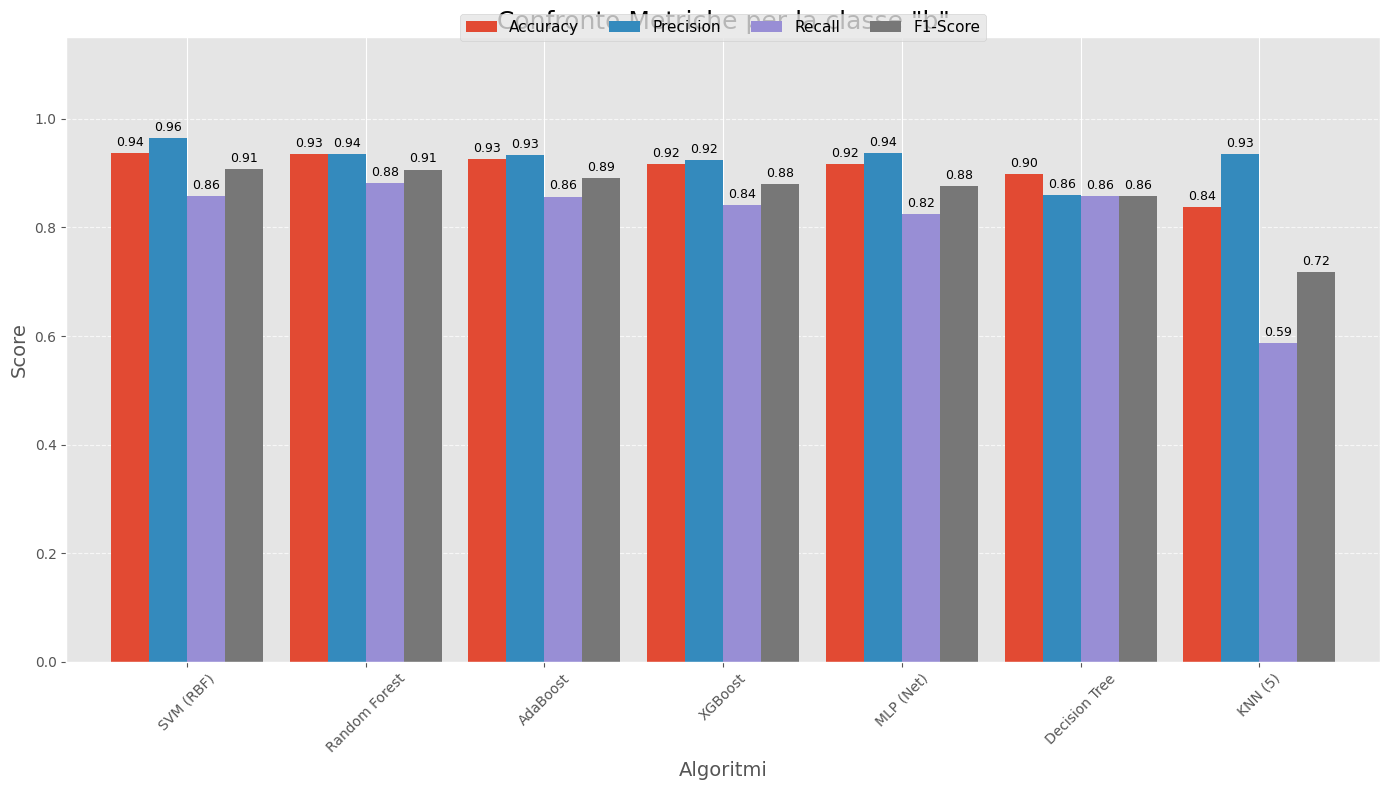

In [69]:
# Separazione Feature (X) e Target (y)
X = df_ionosphere.drop('class', axis=1) # Le 34 feature
y = df_ionosphere['class']              # La colonna "good"/"bad"

# Encoding del Target
# Trasformiamo "good" e "bad" in numeri (es. 0 e 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Verifica veloce della codifica
print(f"Classi rilevate: {le.classes_}")
print(f"Esempio trasformazione: {y.iloc[0]} -> {y_encoded[0]}\n")

# --- CONFIGURAZIONE ---
# Scegli qui: metti 0 oppure 1 a seconda di quale classe vuoi analizzare
TARGET_LABEL = 0  # 0 per "bad", 1 per "good"  
# ----------------------

# Recuperiamo il nome reale della classe scelta (es. "bad" o "good")
# Questo serve per essere sicuri di cosa stiamo misurando
nome_classe_target = le.inverse_transform([TARGET_LABEL])[0]

print(f"IMPOSTAZIONE: Calcolo delle metriche per la classe '{nome_classe_target}' (Codice: {TARGET_LABEL})")
print("-" * 60)


print(f"--- START COMPARAZIONE (Target: {nome_classe_target}) ---")

# Definiamo i 7 Modelli esatti che hai usato
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN (5)":       KNeighborsClassifier(n_neighbors=5),
    "SVM (RBF)":     SVC(kernel='rbf', C=1.0, random_state=42),
    "MLP (Net)":     MLPClassifier(hidden_layer_sizes=(50,25), max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "AdaBoost":      AdaBoostClassifier(n_estimators=100, algorithm='SAMME', random_state=42),
    "XGBoost":       XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, 
                                   eval_metric='logloss', random_state=42)
}

# Metriche da calcolare
scoring_metrics = {
    'Accuracy':  'accuracy',
    'Precision': make_scorer(precision_score, pos_label=TARGET_LABEL),
    'Recall':    make_scorer(recall_score, pos_label=TARGET_LABEL),
    'F1-Score':  make_scorer(f1_score, pos_label=TARGET_LABEL)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# C. ESECUZIONE (TRAINING & TEST)
# ==========================================
results_list = []

for name, model in models.items():
    print(f" > Elaborazione {name}...")
    scores = cross_validate(model, X, y_encoded, cv=cv, scoring=scoring_metrics)
    
    results_list.append({
        "Model": name,
        "Accuracy":  scores['test_Accuracy'].mean(),
        "Precision": scores['test_Precision'].mean(),
        "Recall":    scores['test_Recall'].mean(),
        "F1-Score":  scores['test_F1-Score'].mean()
    })

# Creazione Tabella
df_results = pd.DataFrame(results_list).set_index("Model")
# Ordiniamo per F1-Score decrescente
df_results = df_results.sort_values(by="F1-Score", ascending=False)

print("\n--- TABELLA RISULTATI ---")
print(df_results)

# ==========================================
# D. GENERAZIONE ISTOGRAMMA (GRAFICO A BARRE)
# ==========================================
plt.style.use('ggplot')

ax = df_results.plot(kind='bar', figsize=(14, 8), width=0.85, rot=45)

plt.title(f'Confronto Metriche per la classe "{nome_classe_target}"', fontsize=18)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Algoritmi', fontsize=14)
plt.ylim(0, 1.15) 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Etichette valori sulle barre
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

# Fine Test iperparametri di base

# Inizio ricerca iperparametri ottimali
## NON FINITO

Per ora si è usato il random search (cambiare con grid search). Per ora non si è ottimizzato per eliminare l'over/under fitting.

In [70]:
# Separazione Feature (X) e Target (y)
X = df_ionosphere.drop('class', axis=1) # Le 34 feature
y = df_ionosphere['class']              # La colonna "good"/"bad"

# Encoding del Target
# Trasformiamo "good" e "bad" in numeri (es. 0 e 1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Verifica veloce della codifica
print(f"Classi rilevate: {le.classes_}")
print(f"Esempio trasformazione: {y.iloc[0]} -> {y_encoded[0]}\n")

# --- CONFIGURAZIONE ---
# Scegli qui: metti 0 oppure 1 a seconda di quale classe vuoi analizzare
TARGET_LABEL = 0  # 0 per "bad", 1 per "good"  
# ----------------------

# Recuperiamo il nome reale della classe scelta (es. "bad" o "good")
# Questo serve per essere sicuri di cosa stiamo misurando
nome_classe_target = le.inverse_transform([TARGET_LABEL])[0]

print(f"IMPOSTAZIONE: Calcolo delle metriche per la classe '{nome_classe_target}' (Codice: {TARGET_LABEL})")
print("-" * 60)

# Metriche da calcolare
scoring_metrics = {
    'Accuracy':  'accuracy',
    'Precision': make_scorer(precision_score, pos_label=TARGET_LABEL),
    'Recall':    make_scorer(recall_score, pos_label=TARGET_LABEL),
    'F1-Score':  make_scorer(f1_score, pos_label=TARGET_LABEL)
}

Classi rilevate: ['b' 'g']
Esempio trasformazione: g -> 1

IMPOSTAZIONE: Calcolo delle metriche per la classe 'b' (Codice: 0)
------------------------------------------------------------


#### Decision Tree

In [71]:
# Modello Base
dt = DecisionTreeClassifier(random_state=42)

# 3. Definizione delle DISTRIBUZIONI degli Iperparametri
# Nota: Qui usiamo randint per definire un intervallo, non una lista finita.
param_dist_DT = {
    'criterion': ['gini', 'entropy'],
    
    # randint(1, 50) significa: "Scegli un numero intero a caso tra 1 e 49"
    'max_depth': randint(1, 50), 
    
    # Scegli tra 2 e 20
    'min_samples_split': randint(2, 20),
    
    # Scegli tra 1 e 10
    'min_samples_leaf': randint(1, 10),
    
    # max_features è utilissimo per ridurre l'overfitting con tante colonne
    'max_features': ['sqrt', 'log2', None] 
}

# 4. Configurazione RandomizedSearchCV
n_iter = 200
n_folds = 5
# Importante: Definisco cv qui per riutilizzarlo o cambiarlo facilmente
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(estimator=dt, 
                                   param_distributions=param_dist_DT, 
                                   n_iter=n_iter,                   
                                   cv=cv,                                
                                   scoring=scoring_metrics,          
                                   refit='F1-Score',
                                   return_train_score=True,  # Abilita il calcolo sul training set
                                   n_jobs=-1,                        
                                   random_state=42,                  
                                   verbose=1)

# 5. Esecuzione
print(f"Inizio ottimizzazione randomizzata ({n_iter} iterazioni random)...")
random_search.fit(X, y_encoded)

# =============================================================================
# 2. REPORT DETTAGLIATO: TRAIN vs VAL PER OGNI FOLD
# =============================================================================

idx = random_search.best_index_
results = random_search.cv_results_

print("\n" + "="*60)
print(f"ANALISI OVERFITTING: DETTAGLIO FOLD-BY-FOLD")
print("="*60)
print(f"Migliori parametri: {random_search.best_params_}")

metriche_da_analizzare = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for metrica in metriche_da_analizzare:
    print(f"\n🔹 METRICA: {metrica.upper()}")
    print("-" * 60)
    print(f"{'FOLD':<6} | {'TRAIN Score':<12} | {'VAL Score':<12} | {'GAP':<10}")
    print("-" * 60)
    
    # Accumulatori per calcolare la media alla fine
    tot_train = 0
    tot_val = 0
    
    # Ciclo sui singoli fold (0, 1, 2, 3, 4)
    for k in range(n_folds):
        # Costruiamo le chiavi dinamiche (es. split0_train_Accuracy)
        key_train = f'split{k}_train_{metrica}'
        key_val   = f'split{k}_test_{metrica}' # Ricorda: sklearn chiama il val set 'test'
        
        score_train = results[key_train][idx]
        score_val   = results[key_val][idx]
        gap         = score_train - score_val
        
        tot_train += score_train
        tot_val   += score_val
        
        # Stampa riga del singolo fold
        print(f"#{k:<5} | {score_train:.4f}       | {score_val:.4f}       | {gap:.4f}")

    print("-" * 60)
    # Stampa Media finale
    avg_train = tot_train / n_folds
    avg_val   = tot_val / n_folds
    avg_gap   = avg_train - avg_val
    print(f"{'MEDIA':<6} | {avg_train:.4f}       | {avg_val:.4f}       | {avg_gap:.4f}")
    print("=" * 60)

Inizio ottimizzazione randomizzata (200 iterazioni random)...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits

ANALISI OVERFITTING: DETTAGLIO FOLD-BY-FOLD
Migliori parametri: {'criterion': 'gini', 'max_depth': 17, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2}

🔹 METRICA: ACCURACY
------------------------------------------------------------
FOLD   | TRAIN Score  | VAL Score    | GAP       
------------------------------------------------------------
#0     | 0.9714       | 0.9014       | 0.0700
#1     | 0.9680       | 0.9000       | 0.0680
#2     | 0.9680       | 0.9143       | 0.0537
#3     | 0.9858       | 0.9429       | 0.0429
#4     | 0.9822       | 0.8714       | 0.1108
------------------------------------------------------------
MEDIA  | 0.9751       | 0.9060       | 0.0691

🔹 METRICA: PRECISION
------------------------------------------------------------
FOLD   | TRAIN Score  | VAL Score    | GAP       
--------------------------------------

### KNN

In [72]:
# Modello Base
knn = KNeighborsClassifier()

# 3. Definizione delle DISTRIBUZIONI degli Iperparametri per KNN
param_dist_KNN = {
    # n_neighbors: Il parametro più importante.
    # randint(1, 50) significa: "Prova un numero di vicini a caso tra 1 e 49"
    'n_neighbors': randint(1, 50),
    
    # weights: Come pesare i voti
    # 'uniform' = voto democratico, 'distance' = chi è più vicino conta di più
    'weights': ['uniform', 'distance'],
    
    # p: La metrica di distanza (Potenza di Minkowski)
    # 1 = Distanza Manhattan, 2 = Distanza Euclidea
    'p': [1, 2],
    
    # leaf_size: Parametro tecnico per la velocità dell'algoritmo
    # Non impatta molto la precisione, ma ottimizza il calcolo
    'leaf_size': randint(10, 50)
}

# 4. Configurazione RandomizedSearchCV
n_iter = 200 
# Proverà ESATTAMENTE n_iter combinazioni a caso
random_search = RandomizedSearchCV(estimator=knn, 
                                   param_distributions=param_dist_KNN, 
                                   n_iter=n_iter,                    # NUMERO DI TENTATIVI
                                   cv=5,                             # Cross Validation
                                   scoring=scoring_metrics,          # Metriche da calcolare
                                   refit='F1-Score',                 # Ottimizziamo per F1-Score
                                   n_jobs=-1,                        # Usa tutti i core
                                   random_state=42,                  # Per riproducibilità
                                   verbose=1)

# 5. Esecuzione
print(f"Inizio ottimizzazione randomizzata KNN ({n_iter} iterazioni random)...")
random_search.fit(X, y_encoded)

# 6. Risultati
print(f"Miglior F1-Score (Classe {TARGET_LABEL}): {random_search.best_score_:.4f}")
print(f"Parametri vincenti: {random_search.best_params_}")

# Altre metriche del modello migliore
index_best = random_search.best_index_
acc_best = random_search.cv_results_['mean_test_Accuracy'][index_best]
prec_best = random_search.cv_results_['mean_test_Precision'][index_best]
rec_best = random_search.cv_results_['mean_test_Recall'][index_best]

print(f"L'accuracy di questo modello era: {acc_best:.4f}")
print(f"La precision di questo modello era: {prec_best:.4f}")
print(f"La recall di questo modello era: {rec_best:.4f}")

Inizio ottimizzazione randomizzata KNN (200 iterazioni random)...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Miglior F1-Score (Classe 0): 0.8456
Parametri vincenti: {'leaf_size': 32, 'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}
L'accuracy di questo modello era: 0.9003
La precision di questo modello era: 0.9141
La recall di questo modello era: 0.8022


### SVM

In [73]:
# Modello Base
# Nota: Se vuoi calcolare le probabilità in futuro, dovresti mettere probability=True, 
# ma rallenta molto il training. Per ora lo lasciamo standard.
svm = SVC(random_state=42)

# 3. Definizione delle DISTRIBUZIONI degli Iperparametri per SVM
param_dist_SVM = {
    # C: Parametro di regolarizzazione.
    # loguniform(1e-3, 1e3) pesca numeri tra 0.001 e 1000.
    # È fondamentale usare loguniform perché 0.01 è importante quanto 100.
    'C': loguniform(1e-3, 1e3),
    
    # kernel: Il tipo di matematica usata per separare i dati.
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    
    # gamma: Coefficiente per i kernel 'rbf', 'poly' e 'sigmoid'.
    # Definisce quanto lontano arriva l'influenza di un singolo esempio.
    'gamma': loguniform(1e-4, 1e1),
    
    # degree: Usato solo se il kernel è 'poly'. Ignorato dagli altri.
    'degree': randint(2, 6),
    
    # class_weight: Utile se i dati sono sbilanciati
    'class_weight': [None, 'balanced']
}

# 4. Configurazione RandomizedSearchCV
n_iter = 200 
# Proverà ESATTAMENTE n_iter combinazioni a caso
random_search = RandomizedSearchCV(estimator=svm, 
                                   param_distributions=param_dist_SVM, 
                                   n_iter=n_iter,                    # NUMERO DI TENTATIVI
                                   cv=5,                             # Cross Validation
                                   scoring=scoring_metrics,          # Metriche da calcolare
                                   refit='F1-Score',                 # Ottimizziamo per F1-Score
                                   n_jobs=-1,                        # Usa tutti i core
                                   random_state=42,                  # Per riproducibilità
                                   verbose=1)

# 5. Esecuzione
print(f"Inizio ottimizzazione randomizzata SVM ({n_iter} iterazioni random)...")
random_search.fit(X, y_encoded)

# 6. Risultati
print(f"Miglior F1-Score (Classe {TARGET_LABEL}): {random_search.best_score_:.4f}")
print(f"Parametri vincenti: {random_search.best_params_}")

# Altre metriche del modello migliore
index_best = random_search.best_index_
acc_best = random_search.cv_results_['mean_test_Accuracy'][index_best]
prec_best = random_search.cv_results_['mean_test_Precision'][index_best]
rec_best = random_search.cv_results_['mean_test_Recall'][index_best]

print(f"L'accuracy di questo modello era: {acc_best:.4f}")
print(f"La precision di questo modello era: {prec_best:.4f}")
print(f"La recall di questo modello era: {rec_best:.4f}")

Inizio ottimizzazione randomizzata SVM (200 iterazioni random)...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Miglior F1-Score (Classe 0): 0.9379
Parametri vincenti: {'C': np.float64(3.584985580340472), 'class_weight': None, 'degree': 2, 'gamma': np.float64(0.10907475835157694), 'kernel': 'rbf'}
L'accuracy di questo modello era: 0.9573
La precision di questo modello era: 0.9750
La recall di questo modello era: 0.9046


### Multi Layer Perceptron

In [74]:
# Modello Base
# max_iter=1000 è importante per evitare warning di mancata convergenza durante i test
mlp = MLPClassifier(random_state=42, max_iter=1000)

# 3. Definizione delle DISTRIBUZIONI degli Iperparametri per MLP
param_dist_MLP = {
    # hidden_layer_sizes: Definisce l'architettura della rete.
    # Dobbiamo passare una lista di tuple tra cui scegliere.
    # Esempi: (50,) = 1 strato da 50 neuroni. (100, 50) = 2 strati (100 poi 50).
    'hidden_layer_sizes': [
        (50,),              # Una "imbuto" semplice
        (100,),             # Un layer largo
        (50, 25),           # Due layer a scendere
        (100, 50),          # Due layer larghi
        (100, 50, 25),      # Tre layer (rete profonda)
        (34, 34)            # Due layer uguali al numero delle tue feature
    ],
    
    # activation: La funzione matematica che "accende" i neuroni
    'activation': ['tanh', 'relu', 'logistic'],
    
    # solver: L'algoritmo che aggiusta i pesi.
    # 'adam' è ottimo in generale, 'sgd' può essere più preciso ma richiede più tuning.
    'solver': ['sgd', 'adam'],
    
    # alpha: Regolarizzazione (penalità per evitare overfitting).
    # Usiamo loguniform per esplorare valori da piccolissimi (0.0001) a grandi (0.1)
    'alpha': loguniform(1e-4, 1e-1),
    
    # learning_rate: Strategia di aggiornamento (usata solo se solver='sgd')
    'learning_rate': ['constant', 'adaptive'],
    
    # learning_rate_init: Velocità iniziale di apprendimento.
    # Anche qui scala logaritmica.
    'learning_rate_init': loguniform(1e-4, 1e-1)
}

# 4. Configurazione RandomizedSearchCV
n_iter = 200 
# Proverà ESATTAMENTE n_iter combinazioni a caso
random_search = RandomizedSearchCV(estimator=mlp, 
                                   param_distributions=param_dist_MLP, 
                                   n_iter=n_iter,                    # NUMERO DI TENTATIVI
                                   cv=5,                             # Cross Validation
                                   scoring=scoring_metrics,          # Metriche da calcolare
                                   refit='F1-Score',                 # Ottimizziamo per F1-Score
                                   n_jobs=-1,                        # Usa tutti i core
                                   random_state=42,                  # Per riproducibilità
                                   verbose=1)

# 5. Esecuzione
print(f"Inizio ottimizzazione randomizzata MLP ({n_iter} iterazioni random)...")
# Nota: Potresti vedere dei 'ConvergenceWarning', significa che per quella combinazione specifica
# 1000 iterazioni non sono bastate. È normale durante la ricerca casuale.
random_search.fit(X, y_encoded)

# 6. Risultati
print(f"Miglior F1-Score (Classe {TARGET_LABEL}): {random_search.best_score_:.4f}")
print(f"Parametri vincenti: {random_search.best_params_}")

# Altre metriche del modello migliore
index_best = random_search.best_index_
acc_best = random_search.cv_results_['mean_test_Accuracy'][index_best]
prec_best = random_search.cv_results_['mean_test_Precision'][index_best]
rec_best = random_search.cv_results_['mean_test_Recall'][index_best]

print(f"L'accuracy di questo modello era: {acc_best:.4f}")
print(f"La precision di questo modello era: {prec_best:.4f}")
print(f"La recall di questo modello era: {rec_best:.4f}")

Inizio ottimizzazione randomizzata MLP (200 iterazioni random)...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


KeyboardInterrupt: 